In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

In [2]:
plt.style.use('ggplot')

## Load Data

In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Define transformations and create dataset
transform = transforms.Compose([transforms.Resize((320, 320)), # Resize to LeNet input size
                                transforms.RandomRotation(10), # Randomly rotate the image up to 10 degrees
                                transforms.ToTensor()])

train_dataset = ImageFolder(root="./images/train", transform=transform)
test_dataset = ImageFolder(root="./images/test", transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

## Train Data

In [5]:
import torchvision.models as models

In [6]:
# Initialize the model, loss function, and optimizer
# model = ResNet32().to(device)
model = models.resnet18(pretrained=True).to(device)
num_classes = 3  # Number of classes in your new task

# Modify the last fully connected layer
model.fc = nn.Linear(model.fc.in_features, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/home/muhamuttaqien/miniconda3/envs/tsuc2023/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/muhamuttaqien/miniconda3/envs/tsuc2023/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# Training loop with accuracy tracking
num_epochs = 200
accuracies = []

for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = correct / total
    accuracies.append(accuracy)


    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}")

# Test the model
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Accuracy on valid set: {accuracy * 100:.2f}%")

Epoch 1/200, Loss: 0.3967682421207428
Epoch 2/200, Loss: 0.18100358545780182
Epoch 3/200, Loss: 0.0123932845890522
Epoch 4/200, Loss: 0.17679403722286224
Epoch 5/200, Loss: 0.20832711458206177
Epoch 6/200, Loss: 0.0006518287700600922
Epoch 7/200, Loss: 0.018874675035476685
Epoch 8/200, Loss: 0.010108199901878834
Epoch 9/200, Loss: 0.0010071969591081142
Epoch 10/200, Loss: 0.11292865872383118
Epoch 11/200, Loss: 0.005778427701443434
Epoch 12/200, Loss: 0.0006472570821642876
Epoch 13/200, Loss: 0.0003583028446882963
Epoch 14/200, Loss: 0.061812400817871094
Epoch 15/200, Loss: 0.018655331805348396
Epoch 16/200, Loss: 0.0041380953043699265
Epoch 17/200, Loss: 0.0034238770604133606
Epoch 18/200, Loss: 0.0007884561200626194
Epoch 19/200, Loss: 0.029854824766516685
Epoch 20/200, Loss: 0.38796281814575195
Epoch 21/200, Loss: 0.0002761815267149359
Epoch 22/200, Loss: 0.001396398525685072
Epoch 23/200, Loss: 0.0018781438702717423
Epoch 24/200, Loss: 0.07284049689769745
Epoch 25/200, Loss: 0.0003

KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (200,) and (132,)

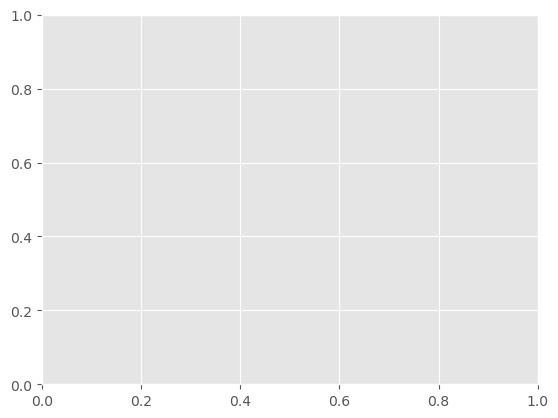

In [8]:
# Plotting the accuracy over epochs
plt.plot(range(1, num_epochs + 1), accuracies)
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

## Test Model

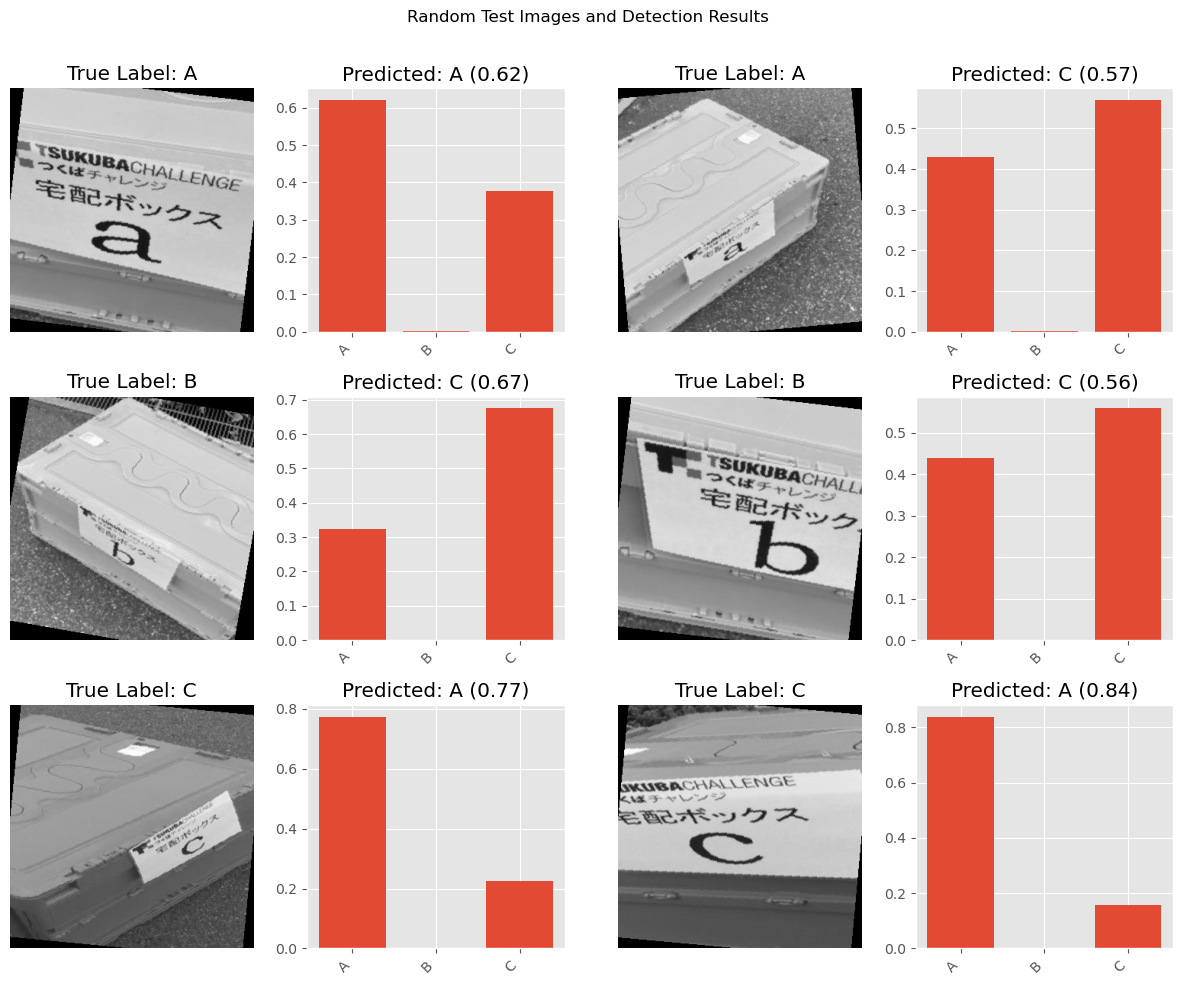

In [9]:
import torchvision.transforms.functional as F

class_names = test_dataset.classes
fig, axes = plt.subplots(3, 4, figsize=(12, 10))
fig.suptitle('Random Test Images and Detection Results')

for i, class_name in enumerate(class_names):
    class_indices = [idx for idx in range(len(test_dataset)) if test_dataset[idx][1] == i]
    selected_indices = random.sample(class_indices, 2)
    
    for j, idx in enumerate(selected_indices):
        input_image, true_label = test_dataset[idx]
        input_image = input_image.unsqueeze(0).to(device)
        
        with torch.no_grad():
            output = model(input_image)
            _, predicted = torch.max(output, 1)
            confidence = torch.softmax(output, dim=1)[0][predicted.item()].item()

        # Squeeze the singleton channel dimension for displaying grayscale image
        input_image = F.to_pil_image(input_image.squeeze())

        axes[i, j * 2].imshow(input_image, cmap='gray')  # Modify this line
        axes[i, j * 2].axis('off')
        axes[i, j * 2].set_title(f'True Label: {class_name}')
        
        axes[i, j * 2 + 1].bar(range(len(class_names)), torch.softmax(output, dim=1).squeeze().cpu().numpy())
        axes[i, j * 2 + 1].set_title(f'Predicted: {class_names[predicted.item()]} ({confidence:.2f})')
        axes[i, j * 2 + 1].set_xticks(range(len(class_names)))
        axes[i, j * 2 + 1].set_xticklabels(class_names, rotation=45, ha='right')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

## Save Model

In [ ]:
torch.save(model, './weights/resnet-pretrained.pt')
torch.save(model.state_dict(), './weights/resnet-pretrained.pth')

---